In [1]:
import stackstac
import satsearch
from datetime import datetime
import dask.diagnostics

import rioxarray
import xarray as xr
import numpy as np
import geopandas as gpd
import geojson
import json

from datetime import datetime

from shapely.geometry import mapping

import zarr

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\stackstac\lib\site-packages\ipykernel\parentpoller.py:110: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


In [13]:
bbox = [150.53718391857018, -34.47320307771639, 151.25748275818813,  -33.82982205634835]  #plot below                    
bbox = [-53.0232820986343754,-8.1236837545427090, -49.4688521093868800,-4.8677173521785928]

In [14]:
import os
%env AWS_NO_SIGN_REQUEST=Yes

t0 = datetime.now()
stac_found = satsearch.Search(
    url="https://explorer.dev.digitalearth.africa/stac/",
    bbox=bbox,
    collections=["esri_land_cover"],
    datetime="2000-02-01/2022-03-31",
).found()  
print(stac_found)

stac_items = satsearch.Search(
    url="https://explorer.dev.digitalearth.africa/stac/",
    bbox=bbox,
    collections=["esri_land_cover"],
    datetime="2000-02-01/2021-03-31",
).items()

print('searching time: {}'.format(datetime.now()-t0))

print("Num of Items", len(stac_items))

t0 = datetime.now()
stack = stackstac.stack(stac_items, epsg=6933, resolution=5000, resampling=1)

print('lazy stacking time: {}'.format(datetime.now()-t0))

print("Stack Size in GB: ", round(stack.nbytes/1e9,0))

stack


env: AWS_NO_SIGN_REQUEST=Yes
2
searching time: 0:00:06.143880
Num of Items 2
lazy stacking time: 0:00:00.202165
Stack Size in GB:  0.0


<xarray.DataArray 'stackstac-4383434de4f8b45456984e757e2e66b0' (time: 2, band: 1, y: 435, x: 140)>
dask.array<fetch_raster_window, shape=(2, 1, 435, 140), dtype=float64, chunksize=(1, 1, 435, 140), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time                  (time) datetime64[ns] 2020-01-01 2020-01-01
    id                    (time) <U36 'c80e9ea1-761c-5ce7-bb50-de93833cb87b' ...
  * band                  (band) <U14 'classification'
  * x                     (x) float64 -5.25e+06 -5.245e+06 ... -4.555e+06
  * y                     (y) float64 1.15e+05 1.1e+05 ... -2.05e+06 -2.055e+06
    title                 (time) <U25 '22M_20200101-20210101.tif' '22L_202001...
    ...                    ...
    cubedash:region_code  (time) <U3 '22M' '22L'
    proj:epsg             int32 32722
    created               <U20 '2020-01-01T00:00:00Z'
    odc:file_format       <U7 'GeoTIFF'
    odc:region_code       (time) <U3 '22M' '22L'
    epsg                  int32 6933
Attributes:
    spec:        RasterSpec(epsg=6933, bounds=(-5250000, -2060000, -4550000, ...
    crs:         epsg:6933
    transform:   | 5000.00, 0.00,-5250000.00|\n| 0.00,-5000.00, 115000.00|\n|...
    resolution:  5000

In [15]:
stack[0]

<xarray.DataArray 'stackstac-4383434de4f8b45456984e757e2e66b0' (band: 1, y: 435, x: 140)>
dask.array<getitem, shape=(1, 435, 140), dtype=float64, chunksize=(1, 435, 140), chunktype=numpy.ndarray>
Coordinates: (12/13)
    time                  datetime64[ns] 2020-01-01
    id                    <U36 'c80e9ea1-761c-5ce7-bb50-de93833cb87b'
  * band                  (band) <U14 'classification'
  * x                     (x) float64 -5.25e+06 -5.245e+06 ... -4.555e+06
  * y                     (y) float64 1.15e+05 1.1e+05 ... -2.05e+06 -2.055e+06
    title                 <U25 '22M_20200101-20210101.tif'
    ...                    ...
    cubedash:region_code  <U3 '22M'
    proj:epsg             int32 32722
    created               <U20 '2020-01-01T00:00:00Z'
    odc:file_format       <U7 'GeoTIFF'
    odc:region_code       <U3 '22M'
    epsg                  int32 6933
Attributes:
    spec:        RasterSpec(epsg=6933, bounds=(-5250000, -2060000, -4550000, ...
    crs:         epsg:6933
    transform:   | 5000.00, 0.00,-5250000.00|\n| 0.00,-5000.00, 115000.00|\n|...
    resolution:  5000

(array([1425., 3334.,    0., 6228.,    0., 5253., 7435.,    0., 2222.,
          42.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

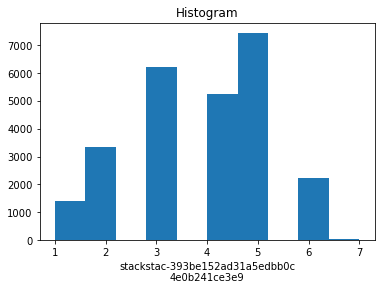

In [7]:
stack.plot()

In [8]:
def median(array, dim, keep_attrs=False, skipna=True, **kwargs):
    """ Runs a median on an dask-backed xarray.
    
    This function does not scale!
    It will rechunk along the given dimension, so make sure 
    your other chunk sizes are small enough that it 
    will fit into memory.
    
    :param DataArray array: An xarray.DataArray wrapping a dask array
    :param dim str: The name of the dim in array to calculate the median
    """
    if type(array) is xr.Dataset:
        return array.apply(median, dim=dim, keep_attrs=keep_attrs, **kwargs)
    
    if not hasattr(array.data, 'dask'):
        return array.median(dim, keep_attrs=keep_attrs, **kwargs)
    
    array = array.chunk({dim:-1})
    axis = array.dims.index(dim)
    median_func = np.nanmedian if skipna else np.median
    blocks = dask.array.map_blocks(median_func, array.data, dtype=array.dtype, drop_axis=axis, axis=axis, **kwargs)
    
    new_coords={k: v for k, v in array.coords.items() if k != dim and dim not in v.dims}
    new_dims = tuple(d for d in array.dims if d != dim)
    new_attrs = array.attrs if keep_attrs else None
    
    return xr.DataArray(blocks, coords=new_coords, dims=new_dims, attrs=new_attrs)

median_stack = median(stack, dim="time")

In [17]:
print(stack.nbytes)


974400


C:\Users\rscott\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


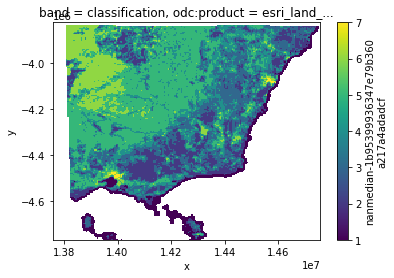

In [9]:
median_stack.plot()

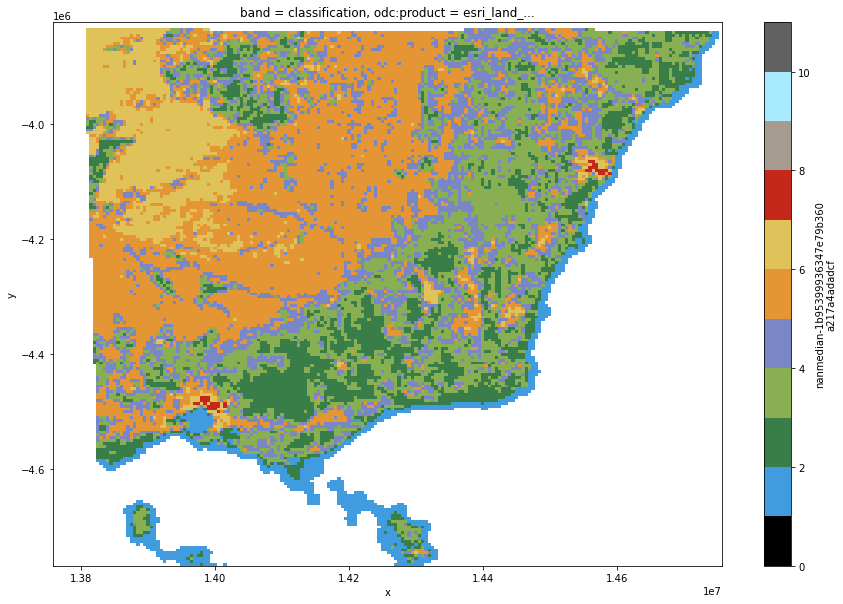

In [12]:
from matplotlib import colors as mcolours

cmap = mcolours.ListedColormap([
      np.array([0, 0, 0]) / 255,
      np.array([65, 155, 223]) / 255,
      np.array([57, 125, 73]) / 255,
      np.array([136, 176, 83]) / 255,
      np.array([122, 135, 198]) / 255,
      np.array([228, 150, 53]) / 255,
      np.array([223, 195, 90]) / 255,
      np.array([196 ,40, 27]) / 255,
      np.array([165, 155, 143]) / 255,
      np.array([168, 235, 255]) / 255,
      np.array([97, 97, 97]) / 255
])
bounds=range(0,12)
norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)


#stack.plot(aspect=1,size=8)

#stack.isel(time=0).squeeze().plot.imshow(cmap=cmap, norm=norm, size=10)

#stack.squeeze().plot.imshow(cmap=cmap, norm=norm, size=10)

median_stack.plot(cmap=cmap, norm=norm, size=10)
